# Training on Fashion MNIST
[Dataset](https://github.com/zalandoresearch/fashion-mnist)

## Loading the data

In [1]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets ar images of range [0, 1]. It need to be transformed to tensor input for CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root="./FMNIST", train=True, download=False, transform=data_transform)
test_data = FashionMNIST(root="./FMNIST", train=False, download=False, transform=data_transform)

print("""
Train data n# images: {}\n
Test data n# images: {}
""" .format(len(train_data), len(test_data)))


Train data n# images: 60000

Test data n# images: 10000



In [2]:
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ["T-Shirt/Top", "Trousser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Visualize some training data


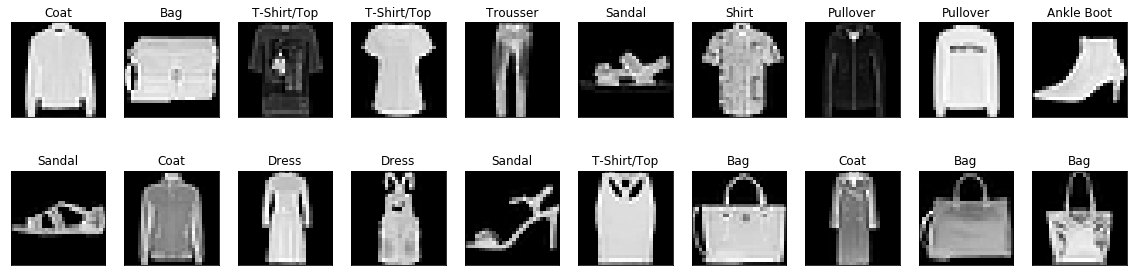

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(20, 5))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title(classes[labels[idx]])

# Network Architecture

Basic concept of network, will be formed by series of:
* Convolutional layers
* Maxpooling layers
* Drop out (p=0.5)
* Fully-connected (linear) layers

The layers of a model is defined in the function \_\_init\_\_ and feedforward is defined as a function forward receiving an input image tensor.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self, drop_p=0.5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*5*5, 10)
        self.fc2 = nn.Linear(50, 10)
        self.drop_out = nn.Dropout(p=drop_p)
        self.maxpool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        
        # Flatten before linear layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_out(x)
        x = self.fc2(x)
        
        return x

net = Net()
print(net)
        

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


# Specify loss function and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [6]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

## Accuracy note
Before and after values

In [7]:
correct = 0
total = 0

for images, labels in test_loader:
    # Forward pass to get output
    outputs = net(images)
    
    # Get the predicted class
    _, predicted = torch.max(outputs.data, 1)
    
    # Count total number of correct labels
    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100 * correct/total
print("Accuracy before training: {:.2f}" .format(accuracy))

RuntimeError: size mismatch, m1: [20 x 10], m2: [50 x 10] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/TH/generic/THTensorMath.cpp:136

# Train the network

In [ ]:
def train(n_epochs):
    loss_over_time = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # Get input images and their labels
            inputs, labels = data
            
            # Zero the parameter gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = net(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass to calculate parameter gradients
            loss.backward()
            
            # Update params
            optimizer.step()
            
            running_loss += loss.item()
            if batch_i % 1000 == 999:
                avg_loss = running_loss/1000
                loss_over_time.append(avg_loss)
                print("Epoch: {}, Batcg: {}, Avg. Loss: {}" .format(epoch+1, batch_i+1, avg_loss))
                running_loss = 0
    print("Finished training")
    return loss_over_time

In [ ]:
n_epochs = 5
training_loss = train(n_epochs)

# Visualize the loss

In [ ]:
plt.plot(training_loss)
plt.xlabel("1000\'s batchs'")
plt.ylabel("loss")
plt.ylim(0, 1.5)
plt.show()

## Test the trained network


In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = predicted.eq(labels.data.view_as(predicted))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Visualize sample test results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx].numpy() else "red"))

# Saving

In [ ]:
# Saving the model
model_dir = 'FMNIST/'
model_name = 'fashion_net_ex.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)